<a href="https://colab.research.google.com/github/Yukkitsune/TBank-Analytics/blob/main/Probability%20theory%20and%20mathematical%20statistics/homework3_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://drive.google.com/file/d/1zX-1WiILrcOHiZuU-iqDfgvt-ICScW0s/view?usp=sharing

In [2]:
!gdown 1zX-1WiILrcOHiZuU-iqDfgvt-ICScW0s

Downloading...
From: https://drive.google.com/uc?id=1zX-1WiILrcOHiZuU-iqDfgvt-ICScW0s
To: /content/statistics_hw3.zip
100% 32.3k/32.3k [00:00<00:00, 45.6MB/s]


In [3]:
!unzip '/content/statistics_hw3.zip'

Archive:  /content/statistics_hw3.zip
  inflating: data_with_test_results.csv  
  inflating: dataset_for_design.csv  


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, norm
from tqdm import tqdm
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
np.random.seed(42)

## Задание 1.
**Проведите исследование того, как мощность T-test зависит от пропорций выборки.**
1) Для этого сгенерируйте выборку из 1000000 значений из нормального распределения со средний значением 100 и СКО 1000.
2) Далее разделите выборку в пропорции 50 на 50
3) Проведите синтетический AB тест, в котором группе B дайте разные размеры эффект (от 1% до 100% с шагом в 10%)
4) Посчитайте вероятность ошибки 2 рода
5) Повторите операции для выборок с пропорцией: 10 на 90, 20 на 80, 30 на 70, 40 на 60, где меньшее значение - это будет размер контрольной группы, а большее - размер тестовой группы
6) Постройте график, где по оси X будет размер эффекта, по оси Y вероятность ошибки 2 рода, а каждая линия соответсвует одной из пропорции

In [5]:
def simulate_beta(
    dist: list,
    dist_size: int,
    effects: list,
    simulations: int,
    propotions: dict,
    alpha=0.05
):
  results = []
  for prop_a, prop_b in tqdm(propotions.items()):
    size_group_a = int(dist_size * prop_a)
    size_group_b = int(dist_size * prop_b)
    for effect in tqdm(effects):
      rejections = 0
      for _ in range(simulations):
        group_a = np.random.choice(dist, replace=True, size=size_group_a)
        group_b = np.random.choice(dist, replace=True, size=size_group_b)
        group_b = group_b * (1 + effect)
        t_stat, p_value = ttest_ind(group_a, group_b)
        if p_value < alpha:
          rejections += 1
      power = rejections / simulations
      t2_error = 1 - power
      results.append({
          'proportion' : f'{prop_a*100}:{prop_b*100}',
          'group_a_size' : size_group_a,
          'group_b_size' : size_group_b,
          'effect' : effect,
          'power' : power,
          't2_error' : t2_error
        })
  return pd.DataFrame(results)

In [6]:
mu, sigma = 100, 1000
size = 1000000
effects = np.arange(0.01, 1.01, 0.1)
norm_dist = np.random.normal(loc=mu, scale=sigma, size=size)
simulations = 100
propotions = {
    0.5:0.5,
    0.1:0.9,
    0.2:0.8,
    0.3:0.7,
    0.4:0.6
}
all_sim_df = simulate_beta(
    dist=norm_dist,
    dist_size=size,
    effects=effects,
    simulations=simulations,
    propotions=propotions)

100%|██████████| 5/5 [02:29<00:00, 29.92s/it]


In [7]:
all_sim_df.to_csv('simulation_results.csv',index=False)

Постройте график, где по оси X будет размер эффекта, по оси Y вероятность ошибки 2 рода, а каждая линия соответсвует одной из пропорции

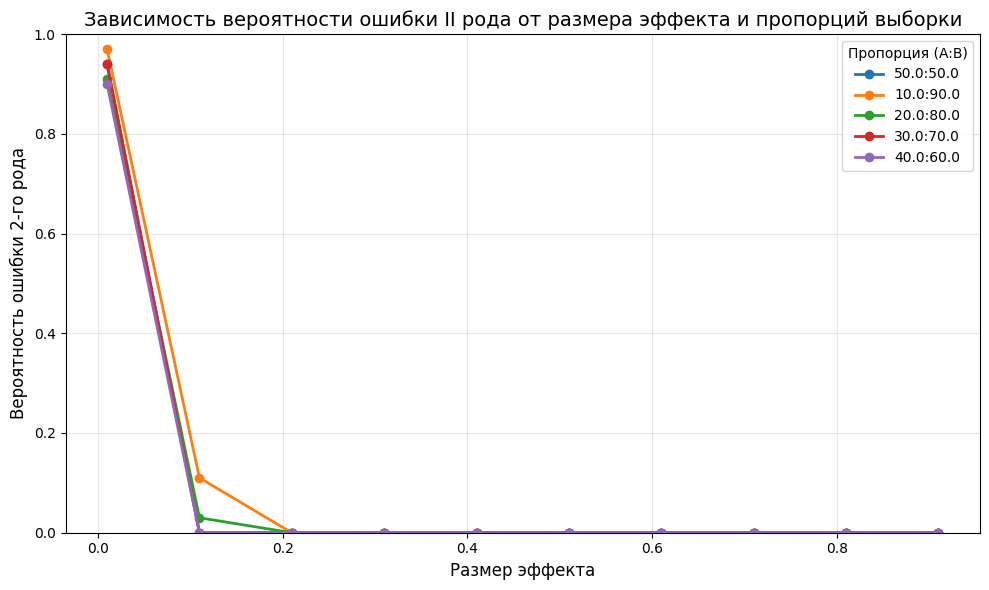

In [8]:
data_for_plot = all_sim_df[['proportion','effect','t2_error']].drop_duplicates().sort_values(by='effect')
plt.figure(figsize=(10, 6))
for proportion in all_sim_df['proportion'].unique():
    prop_data = all_sim_df[all_sim_df['proportion'] == proportion]
    plt.plot(prop_data['effect'],
             prop_data['t2_error'],
             marker='o',
             label=proportion,
             linewidth=2
             )
plt.xlabel('Размер эффекта', fontsize=12)
plt.ylabel('Вероятность ошибки 2-го рода', fontsize=12)
plt.title('Зависимость вероятности ошибки II рода от размера эффекта и пропорций выборки', fontsize=14)
plt.legend(title='Пропорция (A:B)')
plt.grid(alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

По графику видим, что наибольшую ошибку второго рода имеет пропорция 10:90, остальные пропорции имеют примерно одинаковую ошибку при малом эффекте. При возрастании эффекта ошибка второго рода при любой пропорции стремится к нулю.

## Задание 2.
**Подведение результатов эксперимента**
1) Откройте файл с данными `data_with_test_results.csv`
2) Посчитайте посчитайте количество заказов у каждого клиента за период эксперимента
3) Посчитайте насколько значимы изменения среднего количества заказов у клиента в группе B по сравнению с группой А с помощью t-теста и бутстрапа
4) Постройте график с кумулятивным среднийм значеним в группе A и B и посмотрите насколько этот эффект виден

In [9]:
DATA_WITH_TEST_RESULTS = '/content/data_with_test_results.csv'
test_results_df = pd.read_csv(DATA_WITH_TEST_RESULTS, index_col=0)
test_results_df['order_date'] = pd.to_datetime(test_results_df['order_date'])

In [10]:
test_results_df.head()

,user_id,group,order_date,orders_cnt
0,1,A,2025-01-09,1
1,1,A,2025-01-12,3
2,1,A,2025-01-19,1
3,2,B,2025-01-02,1
4,2,B,2025-01-06,1


In [11]:
test_results_df.isnull().mean()

,0
user_id,0.0
group,0.0
order_date,0.0
orders_cnt,0.0


Посчитайте посчитайте количество заказов у каждого клиента за период эксперимента

In [12]:
user_orders_cnt = test_results_df.groupby(['user_id','group'])['orders_cnt'].sum().reset_index()
user_orders_cnt

,user_id,group,orders_cnt
0,1,A,5
1,2,B,4
2,3,A,5
3,4,A,6
4,5,A,6
...,...,...,...
995,996,A,2
996,997,A,3
997,998,B,4
998,999,B,4


Посчитайте насколько значимы изменения среднего количества заказов у клиента в группе B по сравнению с группой А с помощью t-теста и бутстрапа

In [13]:
group_a = user_orders_cnt[user_orders_cnt['group'] == 'A'][['user_id','orders_cnt']]
group_b = user_orders_cnt[user_orders_cnt['group'] == 'B'][['user_id','orders_cnt']]
alpha = 0.05
# Так как не уверен в равенстве дисперсий, решил использовать тест Уэлча
t_stat, p_value = ttest_ind(group_b['orders_cnt'], group_a['orders_cnt'], equal_var=False)
print(f't-test: t_stat = {t_stat}, p_value = {p_value}')
if p_value < alpha:
  print('Есть статистически значимые различия')
else:
  print('Нет статистически значимых различий')

t-test: t_stat = 2.0139768079487577, p_value = 0.04428708996582518
Есть статистически значимые различия


In [14]:
def bootstrap(group_a, group_b, func, N_SIM, alpha: float = 0.05) -> tuple:
  bootstrap_a = np.random.choice(group_a, size=(N_SIM,group_a.shape[0]), replace=True)
  bootstrap_b = np.random.choice(group_b, size=(N_SIM,group_b.shape[0]), replace=True)
  metrics_a = func(bootstrap_a)
  metrics_b = func(bootstrap_b)
  stats = metrics_b - metrics_a
  ci_low = np.quantile(stats, q=alpha/2)
  ci_high = np.quantile(stats, q=1-alpha/2)
  has_effect = (ci_low > 0) or (ci_high < 0)
  return [ci_low, ci_high], has_effect

In [15]:
ci, has_effect = bootstrap(group_a['orders_cnt'], group_b['orders_cnt'], lambda x: np.mean(x, axis=1), 1000)
print(f'Доверительный интервал 95% -> {ci[0], ci[1]}')
print(f'Эффект статистически значим -> {has_effect}')

Доверительный интервал 95% -> (np.float64(0.008053221288514765), np.float64(0.8620598239295718))
Эффект статистически значим -> True


Постройте график с кумулятивным среднийм значеним в группе A и B и посмотрите насколько этот эффект виден

In [16]:
group_a_dated = (test_results_df[test_results_df['group'] == 'A'].groupby('order_date')
.agg(total_orders_in_group=('orders_cnt','sum'),
     unique_users=('user_id','nunique'))
.reset_index())
group_a_dated['cumulative_mean'] = (group_a_dated['total_orders_in_group'].cumsum() / group_a_dated['unique_users'].cumsum())


group_b_dated = (test_results_df[test_results_df['group'] == 'B'].groupby('order_date')
.agg(total_orders_in_group=('orders_cnt','sum'),
     unique_users=('user_id','nunique'))
.reset_index())
group_b_dated['cumulative_mean'] = (group_b_dated['total_orders_in_group'].cumsum() / group_b_dated['unique_users'].cumsum())

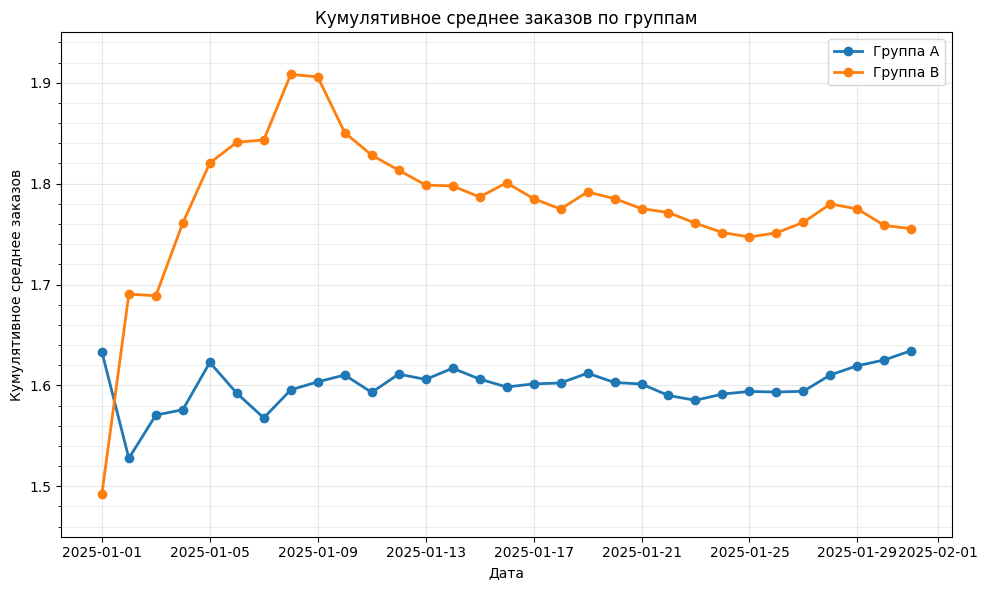

In [17]:
plt.figure(figsize=(10,6))
plt.plot(group_a_dated['order_date'], group_a_dated['cumulative_mean'],
         label='Группа А',linewidth=2, marker='o')
plt.plot(group_b_dated['order_date'], group_b_dated['cumulative_mean'],
         label='Группа B', linewidth=2, marker='o')
plt.title('Кумулятивное среднее заказов по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее заказов')
plt.ylim(1.45,1.95)
plt.grid(alpha=0.3)
plt.legend()
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.02))
ax.grid(True, which='minor', alpha=0.2)
plt.tight_layout()
plt.show()

## Задание 3.
**Дизайн эксперимента**
1) Откройте файл с данными `dataset_for_design`
2) Рассчитайте количество наблюдений, которое необходимо набрать, чтобы у этой метрики увидеть ее увеличение на 5%
3) Проверьте свой ответ с помощью метода Монте-Карло. Покажите, что мощность теста действительно совпадает с заявленной



In [18]:
DATASET_FOR_DESIGN = '/content/dataset_for_design.csv'
design_df = pd.read_csv(DATASET_FOR_DESIGN,index_col=0)

In [19]:
design_df.head()

,user_id,total_orders
0,1,5.481016
1,2,3.514178
2,3,6.091976
3,4,11.242615
4,5,3.286040


In [20]:
design_df.isnull().mean()

,0
user_id,0.0
total_orders,0.0


2) Рассчитайте количество наблюдений, которое необходимо набрать, чтобы у этой метрики увидеть ее увеличение на 5%

In [21]:
current_std = np.std(design_df['total_orders'])
current_mean = np.mean(design_df['total_orders'])

power = 0.8
alpha = 0.05
effect_size = 0.05
delta = effect_size * current_mean

z_alpha = norm.ppf(1 - alpha/2)
z_beta = norm.ppf(power)

n_group = int(np.ceil(2 * pow(current_std, 2) * pow((z_alpha + z_beta), 2) / pow(delta, 2)))
print(f'Размер каждой из групп -> {n_group}')

Размер каждой из групп -> 4288


3) Проверьте свой ответ с помощью метода Монте-Карло. Покажите, что мощность теста действительно совпадает с заявленной

In [36]:
def get_bootstrapped_group(group, size):
  remaining = size
  bootstrapped = []
  while remaining > 0:
    if remaining >= group.size:
      sample_n = group.size
    else:
      sample_n = remaining
    bootstrap_sample = np.random.choice(group, size=sample_n, replace=True)
    bootstrapped.append(bootstrap_sample)
    remaining -= sample_n
  return np.concatenate(bootstrapped)

In [37]:
orders = np.array(design_df['total_orders'])
simulations = 10000
alpha = 0.05
effect_size = 0.05
rejections = 0

for _ in range(simulations):
  control_group = get_bootstrapped_group(group=orders, size=n_group)
  test_group = get_bootstrapped_group(group=orders, size=n_group)
  test_group = test_group * (1 + effect_size)
  t_stat, p_value = ttest_ind(a=control_group, b=test_group)
  if p_value < alpha:
    rejections += 1

emperic_power = rejections / simulations
print(f'Мощность, полученная методом Монте-Карло на выборке объема {n_group} -> {emperic_power}')
print(f'Разница между изначальной мощностью {power} и полученной {emperic_power} -> {abs(power - emperic_power):.4f}')


Мощность, полученная методом Монте-Карло на выборке объема 4288 -> 0.77
Разница между изначальной мощностью 0.8 и полученной 0.77 -> 0.0300
